In [6]:
import numpy as np
import json
import tensorflow as tf

with open('../src/dataset/MPII/mpii_human_pose_v1_u12_1.json', 'r') as json_file:
    data = json.load(json_file)

search_idx = 10
keypoints = data[search_idx]['joint_self']
print(data[search_idx]['img_paths'])
image = tf.io.read_file(filename='./061185289.jpg')
image = tf.io.decode_image(image, channels=3)
image_height, image_width, image_channel = image.shape[:3]
target_width = 256  # Replace with the actual target width
target_height = 256  # Replace with the actual target height
num_keypoints = 14  # Replace with the actual number of keypoints
variance = 3.0  # You can adjust this based on the scale of your dataset

# image_np = image.numpy()
# method_test = tf.image.resize_with_pad(image, target_height, target_width, tf.image.ResizeMethod.BILINEAR).numpy()

import numpy as np
# Function to generate a single Gaussian heatmap for a keypoint
def generate_heatmap(keypoint_x, keypoint_y, image_width, image_height, peak_value = 1.0, variance = 1.0):

    # target_x = keypoint_x // target_width
    # target_y = keypoint_y // target_height

    x = np.arange(0, image_width, 1)
    y = np.arange(0, image_height, 1)
    xv, yv = np.meshgrid(x, y)

    # Calculate the squared distance from each pixel to the keypoint
    distance_squared = (xv - keypoint_x)**2 + (yv - keypoint_y)**2

    # Create a heatmap with zeros
    heatmap = np.zeros((image_height, image_width),dtype=np.float32)

    # Set the value at the keypoint to the peak_value
    heatmap[int(keypoint_y), int(keypoint_x)] = peak_value

    # Optionally, apply Gaussian smoothing to the peak
    heatmap = peak_value * np.exp(-distance_squared / (2.0 * variance ** 2))

    return heatmap



061185289.jpg
0 255
0.0 255.0


In [32]:
image_resized = tf.image.resize_with_pad(image, target_height, target_width)
heatmaps = np.zeros((num_keypoints, image_height, image_width))
heatmaps_resized = tf.image.resize_with_pad(heatmaps, target_height, target_width, )

for i in range(num_keypoints):
    keypoint_x, keypoint_y, visibility = keypoints[i]  # Replace with your actual keypoint data
    if visibility > 0.5:  # You can adjust this threshold based on your dataset
        heatmap = generate_heatmap(keypoint_x, keypoint_y, image_width, image_height, variance)
        heatmaps[i] = heatmap


In [33]:
ground_truth_heatmap = np.stack(heatmaps, axis=-1)
print(ground_truth_heatmap.shape)

(720, 1280, 14)


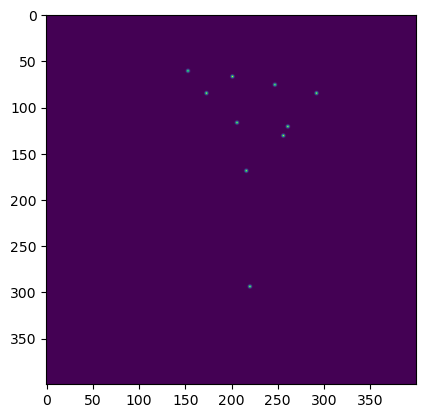

In [53]:
import matplotlib.pyplot as plt
vis = np.zeros((target_height, target_width))

for idx in range(ground_truth_heatmap.shape[-1]):
    vis += ground_truth_heatmap[:,:,idx]

plt.imshow(vis[100:500, 400:800])